# Продвинутый уровень: реализация алгоритма PCA

**ДИСКЛЕЙМЕР** урок содержит большое количество формул и питоновского кода, который нужен для глубокого погружения в тему. Успешно применять PCA можно и без этого урока, но если вы хотите отколоть кусок побольше от гранита науки - добро пожаловать в этот урок. Если материал покажется слишком сложным, ничего страшного - просто переходите к следующему уроку. Если захотите подготовиться к освоению этого, освежите в памяти такие термины как: ковариация, математическое ожидание, дисперсия, собственные значения и собственные вектора. Готовы? Поехали!

Вычисление главных компонент сводится к вычислению собственных векторов и собственных значений ковариационной матрицы исходных данных. Чтобы реализовать этот алгоритм, введём понятие ковариации.

Ковариация признаков $X_i$ и $X_j$:

$$
cov(X_i, X_j) = E[(X_i-\mu_i)(X_j-\mu_j)] = E[X_iX_j] - \mu_i\mu_j
$$

На диагонали этой матрицы стоят дисперсии признаков, т.к. $cov[X_iX_i] = D[X_i]$.

Для экспериментов загрузим из пикла случайный датасет небольшого размера

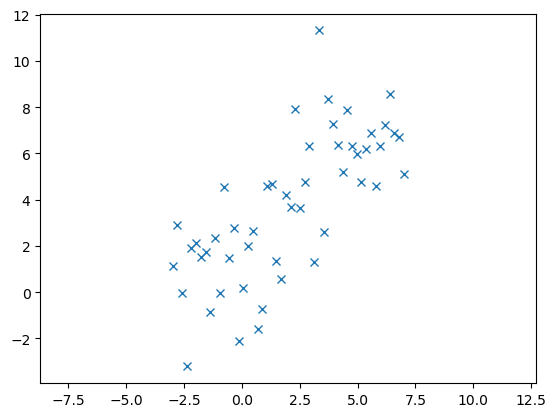

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

with open('eigen.pkl', 'rb') as f:
    X = pickle.load(f)

plt.plot(X[:,0], X[:,1], 'x')
plt.axis('equal')
plt.show()

Мы получили две фичи $x_1$ и $x_2$, которые сильно коррелируют друг с другом (потому что мы их специально сгенерировали таким образом). Объединим их в уже известную нам матрицу *объекты-признаки* наблюдений размеров $N \times 2$.

Формула ковариации подсказывает, что для упрощения вычислений данные предварительно нужно центрировать, то есть вычесть из каждого столбца матрицы наблюдений среднее. На графике видно, что данные при этом не изменили свою форму, зато немного "съехали" в сторону начала координат.

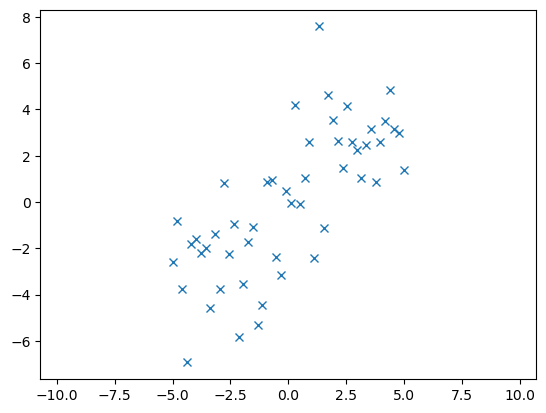

In [2]:
# Центрируем координаты
mean_val = X.mean(axis=0)
N = X.shape[0]
X_centered = X.copy() - mean_val

plt.plot(X_centered[:,0], X_centered[:,1], 'x')
plt.axis('equal')
plt.show()

Выборочная ковариация вычисляется как сумма квадратичных отклонений:
$$
\left\{
\begin{array}{c}
cov(X_i, X_i) = Var(X_i) = \frac{\sum_{i=1}^{N}\left(x_i - \overline{x_i}\right)^2}{n-1}\\
cov(X_i, X_j) = \frac{\sum_{i=1}^{N}\left(x_i - \overline{x_i}\right)\left(x_j - \overline{x_j}\right)}{n-1}
\end{array}
\right.
$$

В нашем случае данные центрированы, то есть отклонение от точки совпадает с значением этой точки, то есть ковариационную матрицу можно вычислить просто с помощью матричного умножения (неплохой пример с этими формулами можно [найти тут](https://towardsdatascience.com/let-us-understand-the-correlation-matrix-and-covariance-matrix-d42e6b643c22)):

In [5]:
# вычисляем ковариационную матрицу "по определению"
X_cov = X_centered.T.dot(
    X_centered
) / (N-1)
print("Ковариационная матрица:\n{}\n".format(
    X_cov)
)
# готовая реализация из numpy
print("Ковариационная матрица из numpy:\n{}\n".format(
    np.cov(X_centered, rowvar=0))
)

Ковариационная матрица:
[[8.85047897 6.81117445]
 [6.81117445 9.95969352]]

Ковариационная матрица из numpy:
[[8.85047897 6.81117445]
 [6.81117445 9.95969352]]


Вычисленная "по определению" матрица ковариации совпадает с реализацией из numpy - мы на правильном пути! Кстати, можно заметить что матрица является симметричной, а так же что все её элементы - положительные числа.

В линейной алгебре существует концепция "собственных векторов"(eigenvectors) и "собственных чисел"(igenvalues). Если по-простому, то у матрицы $A$ существует собственный вектор $w_i$ и собственное число $\lambda_i$, если выполняется соотношение
$$
Aw_i = \lambda_iw_i
$$

Есть несколько особенностей: СВ и СЗ существуют только у квадратных матриц, причём количество собственных значений соответствует размерности матрицы $n$.

Итак, мы хотим найти такие векторы (те самые главные компоненты), при проекции (то есть умножении) на которые наши данные сохранят максимальную долю своей дисперсии. Эти векторы являются просто собственными векторами ковариационной матрицы! Мы используем это утверждение как факт, а математическим обоснованием этого факта является [соотношение Релея](https://ru.wikipedia.org/wiki/Отношение_Рэлея)

В `numpy` есть функция для вычисления СВ, СЗ (которая является обёрткой над системным пакетом [LAPACK](https://ru.wikipedia.org/wiki/LAPACK ))

In [6]:
from numpy import linalg

eigenvalues, eigenvectors = linalg.eig(X_cov)

print(''.join(
    'lambda_{} ={}, w = {}\n'.format(eig_id,eigenvalues[eig_id], eigenvectors[:,eig_id])
    for eig_id in range(eigenvalues.size))
)

lambda_0 =2.571369350737129, w = [-0.7352406   0.67780621]
lambda_1 =16.238803136510406, w = [-0.67780621 -0.7352406 ]


Отобразим оба вектора на графике, ведь у matplotlib есть специальная функция для отрисовки векторных полей

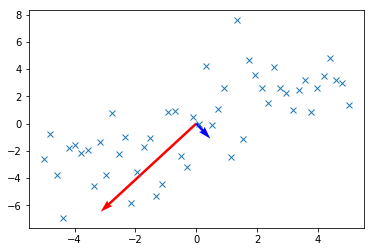

In [ ]:
origin = X_centered.mean(axis=0) # начало координат

# транспонируем матрицу собственных векторов, чтобы собственный вектор соответствовал строке
plt.quiver(*origin, *eigenvectors.T, color=['r','b','g'], scale=eigenvalues)
plt.plot(X_centered[:,0], X_centered[:,1], 'x')

У нас два признака, которым  соответствуют два собственных вектора. Выберем собственный вектор, который соответствует максимальному собственному значению и умножим на него нашу матрицу наблюдений. То есть у нас были двумерные данные, а мы перешли к одномерным

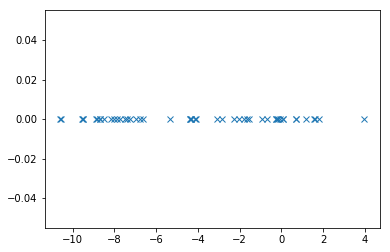

In [ ]:
# первой главной компоненте соответствует самое больше собственное значение
max_eigenval = np.argmax(eigenvalues)
# главная компонента, соответствующая первому собственному значению
max_eigenvec = eigenvectors[:,max_eigenval].reshape(-1,1)

# X_redused = X.dot(max_eigenvec.reshape(1,-1).T)
X_redused = X.dot(max_eigenvec)

plt.plot(X_redused, np.zeros(N), 'x')

Произведём обратное преобразование - перейдем от одномерного случая к двумерному

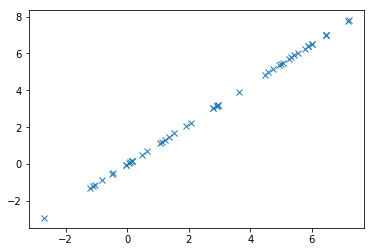

In [ ]:
X_inverse = X_redused.dot(max_eigenvec.reshape(1,-1))

plt.plot(X_inverse[:,0], X_inverse[:,1], 'x')

plt.show()

Мы спроецировали наши данные из двумерного пространства в одномерное - из плоскости на линию -  с помощью алгоритма PCA. Видно, что проекция сохраняет в каком-то виде структуру данных (сгущения данных, например, становятся более отчётливо видны).

Свойства главных компонент:

* каждая главная компонента имеет максимально возможную дисперсию.  Все главные компоненты пронумерованы, с ростом номера главной компоненты уменьшается и доля дисперсии, которую "объясняет" эта компонента
* Корреляция между двумя любыми компонентами равна нулю (т.е. они некоррелированы)

В этом уроке мы:

* реализовали PCA на языке Python без использования библиотечный функций, прокачав навыки программирования
* узнали несколько математических понятий: собственные векторы, собственные значения, ковариационная матрица
* научились визуализировать вектора главных компонент

В следующем уроке мы рассмотрели ещё один метод понижения размерности, который называется SVD.